# HelpMate AI

## Business Objective

<p> The primary business objective is to develop Mr.HelpMate AI, an intelligent search assistant that enables users to get quick and accurate answers from complex life insurance policy documents. This initiative aims to improve customer satisfaction and increase operational efficiency by reducing the time required to find policy-specific information.  </p>

<h1> RAG system Design with detailed Steps </h1>

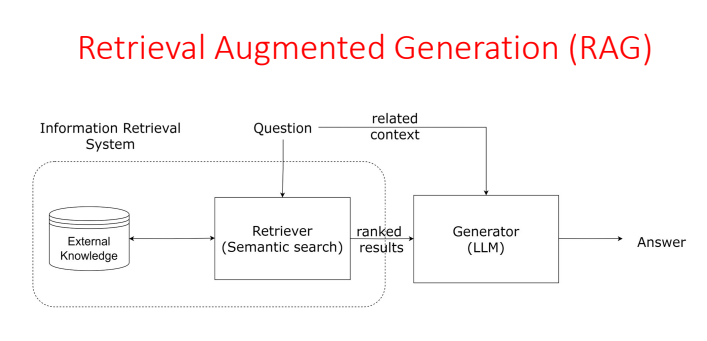

<h2> You need to perform the following tasks to complete the assignment: </h2>

<ol type="1">

  <li> Input Data Structure and Indentify Chunking strategy
  <li> Document Chunking
  <li> Embedding Layer (Create and Store)
  <li> Retriever (Semantic Search, Caching & Reranking)
  <li> Generation (Q&A using LLM)
  <li> Summary      
</ol>

## Installing required Libraries

In [60]:
# Install the following packages incase they're not loaded already
# !pip install --upgrade pdfplumber
# !pip install --upgrade  googleapis-common-protos
# !pip install --upgrade  chromadb
# !pip install --upgrade  tiktoken
# !pip install --upgrade openai
# !pip install --upgrade sentence-transformers
# !pip install --upgrade tf-keras
# !pip install --upgrade "posthog<3.0.0" # To remove ChromaDB error for positional arguments (3 instead of 1)

In [61]:
import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb
import os

# Import the SentenceTransformer library
from sentence_transformers import SentenceTransformer, util

# Import the CrossEncoder library from sentence_transformers
from sentence_transformers import CrossEncoder, util

## Document Chunking

In [62]:
pdf_path = 'Principal-Sample-Life-Insurance-Policy.pdf' 
if not os.path.exists(pdf_path):
    print(f"Error: The file '{pdf_path}' was not found.")
else:
    # Use a 'with' statement to automatically close the file
    with pdfplumber.open(pdf_path) as pdf:
        print(f"Successfully opened '{pdf_path}'")
        print(f"Number of pages: {len(pdf.pages)}\n")
    # Get one of the pages from the PDF and examine it
        single_page = pdf.pages[6]

    # Extract text from the first page
        text = single_page.extract_text()

    # Extract tables from the first page
        tables = single_page.extract_tables()

    # Print the extracted text
        print(text)

Successfully opened 'Principal-Sample-Life-Insurance-Policy.pdf'
Number of pages: 64

Section A – Eligibility
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section B - Effective Dates
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Section C - Individual Terminations
Member Life Insurance Article 1
Member Accidental Death and Dismemberment Insurance Article 2
Dependent Life Insurance Article 3
Termination for Fraud Article 4
Coverage While Outside of the United States Article 5
Section D - Continuation
Member Life Insurance Article 1
Dependent Insurance - Developmentally Disabled or
Physically Handicapped Children Article 2
Section E - Reinstatement
Reinstatement Article 1
Federal Required Family and Medical Leave Act (FMLA) Article 2
Reinstatement of Coverage for a Member or Dependent When
Coverage Ends due to Living Outsid

In [63]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [64]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

### Extract Data using above defined functions

In [65]:

# Initialize an empty list to store the extracted texts and document names
data = []

# Process the PDF file
print(f"...Processing {pdf_path}")

# Call the function to extract the text from the PDF
extracted_text = extract_text_from_pdf(pdf_path)

# Convert the extracted list to a PDF, and add a column to store document names
extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])

# Append the extracted text and document name to the list
data.append(extracted_text_df)

# Print a message to indicate progress
print(f"Finished processing {pdf_path}")

# Print a message to indicate all PDFs have been processed
print("PDF have been processed.")

...Processing Principal-Sample-Life-Insurance-Policy.pdf
Finished processing Principal-Sample-Life-Insurance-Policy.pdf
PDF have been processed.


In [66]:
# Print the created Data frame
data

[   Page No.                                          Page_Text
 0    Page 1  DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
 1    Page 2                 This page left blank intentionally
 2    Page 3  POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
 3    Page 4                 This page left blank intentionally
 4    Page 5  PRINCIPAL LIFE INSURANCE COMPANY (called The P...
 ..      ...                                                ...
 59  Page 60  I f a Dependent who was insured dies during th...
 60  Page 61  Section D - Claim Procedures Article 1 - Notic...
 61  Page 62  A claimant may request an appeal of a claim de...
 62  Page 63                 This page left blank intentionally
 63  Page 64  Principal Life Insurance Company Des Moines, I...
 
 [64 rows x 2 columns]]

In [67]:
insurance_pdfs_data = pd.concat(data, ignore_index=True)
insurance_pdfs_data

,Page No.,Page_Text
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...
1,Page 2,This page left blank intentionally
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...
3,Page 4,This page left blank intentionally
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...
...,...,...
59,Page 60,I f a Dependent who was insured dies during th...
60,Page 61,Section D - Claim Procedures Article 1 - Notic...
61,Page 62,A claimant may request an appeal of a claim de...
62,Page 63,This page left blank intentionally


In [68]:
# Store the metadata for each page in a separate column, now we can consider the Page_No is the metadata
insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Page_No.': x['Page No.']}, axis=1)
insurance_pdfs_data

,Page No.,Page_Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'}
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'}
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'}
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'}
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'}
...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'}
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'}
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'}
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'}


In [69]:
# Check one of the extracted page texts to ensure that the text has been correctly read
insurance_pdfs_data.Page_Text[55]

'If a Member sustains an injury, and as a result of such injury, one or more of the covered losses listed below are incurred, The Principal will pay the following percentages of the Member\'s Scheduled Benefit (or approved amount, if applicable) in force, provided all Benefit Qualifications as described in Article 2 are met. % of Scheduled Covered Loss Benefit Loss of Use or Paralysis Quadriplegia 100% Paraplegia 50% Hemiplegia 50% Both Hands or Both Feet 50% One Hand and One Foot 50% One Arm or One Leg 25% One Hand or One Foot 25% The Principal does not pay an Accidental Death and Dismemberment benefit for any paralysis caused by a stroke. Paralysis must be determined by a Physician to be permanent, complete, and irreversible. Total payment for all losses that result from the same accident will not exceed the Scheduled Benefit (or approved amount, if applicable). Payment for Loss will be to the Member. For this benefit, the term "Loss of Use" means a total and irrevocable loss of volu

In [70]:
## As observed on the document, there are quite a few blank pages mentioned as left blank intentionally.
## We shall get rid of such pages.
## So, it is wise to add text lenght on metadata and remove such pages records from dataframe

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))
insurance_pdfs_data

,Page No.,Page_Text,Metadata,Text_Length
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,{'Page_No.': 'Page 1'},30
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
2,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,{'Page_No.': 'Page 3'},230
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,{'Page_No.': 'Page 5'},110
...,...,...,...,...
59,Page 60,I f a Dependent who was insured dies during th...,{'Page_No.': 'Page 60'},285
60,Page 61,Section D - Claim Procedures Article 1 - Notic...,{'Page_No.': 'Page 61'},418
61,Page 62,A claimant may request an appeal of a claim de...,{'Page_No.': 'Page 62'},322
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5


In [71]:
insurance_pdfs_data[insurance_pdfs_data['Text_Length']<10]

,Page No.,Page_Text,Metadata,Text_Length
1,Page 2,This page left blank intentionally,{'Page_No.': 'Page 2'},5
3,Page 4,This page left blank intentionally,{'Page_No.': 'Page 4'},5
62,Page 63,This page left blank intentionally,{'Page_No.': 'Page 63'},5
63,Page 64,"Principal Life Insurance Company Des Moines, I...",{'Page_No.': 'Page 64'},8


In [72]:
#Drop these records

insurance_pdfs_data = insurance_pdfs_data[insurance_pdfs_data['Text_Length']>10]

## Create Embedding

### We will generate embeddings for texts extracted from Insurance PDF. But the document contains several pages and huge text, before generating the embeddings, we need to generate the chunks. Let's start with a basic chunking technique, and chunk the text with fixed size.

## Fixed-Size Chunking

In fixed-size chunking, the document is split into fixed-size windows with each window representing a separate document chunk.

In [73]:
# Function to split text into fixed-size chunks
def split_text_into_chunks(text, chunk_size):
    chunks = []
    words = text.split()  # Split the text into words

    current_chunk = []  # Store words for the current chunk
    current_chunk_word_count = 0  # Count of words in the current chunk

    for word in words:
        if current_chunk_word_count + len(word) + 1 <= chunk_size:
            current_chunk.append(word)
            current_chunk_word_count += len(word) + 1
        else:
            chunks.append(' '.join(current_chunk))
            current_chunk = [word]
            current_chunk_word_count = len(word)

    if current_chunk:
        chunks.append(' '.join(current_chunk))

    return chunks## 3. <font color = 'red'> Generating Embeddings </font>

#### Encoding Pipeline

In [74]:
def process_page(page_no):
    page = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Page_Text.values[0]
    metadata = insurance_pdfs_data[insurance_pdfs_data['Page No.'] == page_no].Metadata.values[0]

    if page is not None:
        # setting chunk size fixed length as 500
        chunk_size = 500
        text_chunks = split_text_into_chunks(page, chunk_size)

        # Creating a DataFrame to store the chunks, page title and page metadata
        data = {'Title': [], 'Chunk Text': [], 'Metadata': []}

        for index, chunk in enumerate(text_chunks):
            data['Title'].append(page_no)
            data['Chunk Text'].append(chunk)
            # adding chunk no as part of metadata
            metadata['Chunk_No.'] = index
            data['Metadata'].append(metadata)

        return pd.DataFrame(data)

In [75]:
# creating a dataframe after calling process
all_dfs = []
page_nos = insurance_pdfs_data["Page No."]
for page_no in page_nos:
    df = process_page(page_no)
    if df is not None:
        all_dfs.append(df)

fixed_chunk_df = pd.concat(all_dfs, ignore_index=True)
fixed_chunk_df

,Title,Chunk Text,Metadata
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}"
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
2,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
3,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}"
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,"{'Page_No.': 'Page 5', 'Chunk_No.': 1}"
...,...,...,...
222,Page 61,incomplete claim. Written notification will be...,"{'Page_No.': 'Page 61', 'Chunk_No.': 4}"
223,Page 62,A claimant may request an appeal of a claim de...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
224,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}"
225,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}"


## Store Embedding in VectorDB (Chroma)

In [76]:
# Load the embedding model
model_name = "all-MiniLM-L6-v2"
embedder = SentenceTransformer(model_name)

In [77]:
# Function to generate embeddings for text
def generate_embeddings(texts):
    embeddings = embedder.encode(texts, convert_to_tensor=False)
    return embeddings

In [78]:
# function to generate embedding on dataframe
def generate_embeddings_on_df(df):
  df['Embeddings'] = df['Chunk Text'].apply(lambda x: generate_embeddings([x])[0])

In [79]:
# Create embeddings for 'Chunk Text' column on all three dataframes
generate_embeddings_on_df(fixed_chunk_df)

In [80]:
# print the dataframe
fixed_chunk_df

,Title,Chunk Text,Metadata,Embeddings
0,Page 1,DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/...,"{'Page_No.': 'Page 1', 'Chunk_No.': 0}","[-0.025921954, 0.04777747, 0.055857696, 0.0423..."
1,Page 3,POLICY RIDER GROUP INSURANCE POLICY NO: S655 C...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.064537905, 0.043197103, -8.387588e-05, -0...."
2,Page 3,arrange for third party service providers (i.e...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.10200983, -0.028467732, -0.020565085, -0.0..."
3,Page 3,the provision of such goods and/or services no...,"{'Page_No.': 'Page 3', 'Chunk_No.': 2}","[-0.09000838, 0.076582, 0.004927631, -0.083075..."
4,Page 5,PRINCIPAL LIFE INSURANCE COMPANY (called The P...,"{'Page_No.': 'Page 5', 'Chunk_No.': 1}","[-0.055241942, 0.06727762, 0.06015326, -0.0329..."
...,...,...,...,...
222,Page 61,incomplete claim. Written notification will be...,"{'Page_No.': 'Page 61', 'Chunk_No.': 4}","[-0.1215309, 0.07334653, 0.07973092, -0.030015..."
223,Page 62,A claimant may request an appeal of a claim de...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.051644683, 0.124283835, 0.057106256, -0.04..."
224,Page 62,"requested additional information, The Principa...","{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.047671903, 0.112776935, 0.069064885, -0.05..."
225,Page 62,may have the Member or Dependent whose loss is...,"{'Page_No.': 'Page 62', 'Chunk_No.': 3}","[-0.079419956, 0.14404447, 0.03187611, -0.0655..."


In [81]:
# Define the path where chroma collections will be stored
chroma_data_path = './'

In [82]:
# Call PersistentClient()
client = chromadb.PersistentClient(path=chroma_data_path)

In [83]:
# Create a collection to store the embeddings. Collections in Chroma are where you can store your embeddings, documents, and any additional metadata.
collection = client.get_or_create_collection(name="insurance-collection")

In [84]:
collection.add(
    embeddings = fixed_chunk_df['Embeddings'].to_list(),
    documents = fixed_chunk_df['Chunk Text'].to_list(),
    metadatas = fixed_chunk_df['Metadata'].to_list(),
    ids = [str(i) for i in range(0, len(fixed_chunk_df['Embeddings']))]
)

In [85]:
# get few of data by ids from collection
collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-2.59219538e-02,  4.77774702e-02,  5.58576956e-02, ...,
         -4.93265204e-02, -5.85114323e-02,  2.35519502e-02],
        [-6.45379052e-02,  4.31971028e-02, -8.38758788e-05, ...,
         -3.78733911e-02,  1.79674551e-02, -7.36602396e-03],
        [-1.02009833e-01, -2.84677316e-02, -2.05650851e-02, ...,
         -7.84531012e-02,  8.26104507e-02,  3.99261975e-04]]),
 'documents': ['DOROTHEA GLAUSE S655 RHODE ISLAND JOHN DOE 01/01/2014 711 HIGH STREET GEORGE RI 02903 GROUP POLICY FOR: RHODE ISLAND JOHN DOE ALL MEMBERS Group Member Life Insurance Print Date: 07/16/2014',
  'POLICY RIDER GROUP INSURANCE POLICY NO: S655 COVERAGE: Life EMPLOYER: RHODE ISLAND JOHN DOE Effective on the later of the Date of Issue of this Group Policy or March 1, 2005, the following will apply to your Policy: From time to time The Principal may offer or provide certain employer groups who apply for coverage with The Principal a Financial Services Hotline and Gri

In [86]:
# create a cache collection
cache_collection = client.get_or_create_collection(name='insurance-collection-cache')

In [87]:
# peek few of elements from cache collection
cache_collection.peek()

{'ids': ['how disability gets covered in Life insurance coverage',
  'what is the Proof of ADL Disability or Total Disability',
  'what is condition of death while not wearing Seat Belt',
  'Who is considered a dependent, and what are their fundamental rights to life insurance coverage?',
  'Can a dependent life insurance benefit be changed or terminated without their consent, especially in cases of divorce or beneficiary disputes? ',
  'Can a dependent life insurance be terminatedce and in which scenario? ',
  'What are the rights and procedures for a dependent, particularly a minor, to claim life insurance benefits, and how can a dependent contest a beneficiary designation?'],
 'embeddings': array([[-0.04032157,  0.12054248, -0.02357201, ..., -0.04798831,
          0.11429858,  0.08919971],
        [-0.11262888,  0.05175915, -0.0046567 , ...,  0.10451434,
          0.02804656,  0.03974167],
        [ 0.02813488,  0.08606375, -0.04085079, ..., -0.03272637,
         -0.04479829,  0.011

## Semantic Search (Retriever)

## Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [88]:
# Read the user query
query = input()

 Who is considered a dependent, and what are their fundamental rights to life insurance coverage?


In [89]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results
cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [90]:
# get result from cache collection
cache_results

{'ids': [['Who is considered a dependent, and what are their fundamental rights to life insurance coverage?']],
 'embeddings': None,
 'documents': [['Who is considered a dependent, and what are their fundamental rights to life insurance coverage?']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'distances4': '0.7876288890838623',
    'documents3': 'any Accelerated Benefit payment as described in PART IV, Section A, Article 7. Article 2 - Dependent Life Insurance a. Individual Policy If a Dependent qualifies and makes timely application, he or she may purchase an individual policy of life insurance under these terms: (1) The Dependent will not be required to submit Proof of Good Health. (2) The policy will be for life insurance only. No disability or other benefits will be included. (3) The policy will be on one of the forms, other than',
    'distances5': '0.8119557499885559',
    'metadatas4': "{'Chunk_No.': 4, 'Page_No.': 'Page 

In [91]:
# get result from main collection
results = collection.query(
query_texts=query,
n_results=10
)
print("Result size is : " + str(len(results.items())))
results.items()

Result size is : 8


dict_items([('ids', [['147', '105', '77', '145', '148', '52', '120', '106', '214', '11']]), ('embeddings', None), ('documents', [["(4) Premium will be based on the Dependent's age and the standard rate of The Principal for the policy form to be issued. b. Purchase Qualification A Dependent will qualify for individual purchase if: (1) Dependent Life Insurance, or any portion of it, terminates because he or she ceases to be a Dependent as defined in PART I; or because the Member dies, ends Active Work, or ceases to be in a class eligible for such insurance; or (2) the Dependent spouse's Dependent Life Insurance terminates as", 'Life Insurance Dependent Life Insurance is available only with respect to Dependents of Members currently insured for Member Life Insurance. If a Member is eligible for Dependent Life Insurance, such insurance will be effective under the same terms as set forth for Member Life Insurance in this Section B, Article 1, except as described below. This policy has been 

In [92]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      size = len(results.items())

      for key, val in results.items():
        if val is None:
          continue
        for i in range(size):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })

Found in cache!


In [93]:
# print the results
results_df

,IDs,Documents,Distances,Metadatas
0,105,any Accelerated Benefit payment as described i...,0.7876288890838623,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}"
1,145,"described in PART III, Section C; or (3) the D...",0.8119557499885559,"{'Chunk_No.': 3, 'Page_No.': 'Page 36'}"
2,147,Member or Dependent is temporarily outside the...,0.6720605492591858,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}"
3,120,Rights A Dependent will have no rights under t...,0.8453948497772217,"{'Page_No.': 'Page 33', 'Chunk_No.': 5}"
4,77,a . In no event will Dependent Life Insurance ...,0.695526123046875,"{'Chunk_No.': 3, 'Page_No.': 'Page 18'}"
5,148,(4) Premium will be based on the Dependent's a...,0.7748057246208191,"{'Chunk_No.': 4, 'Page_No.': 'Page 32'}"
6,52,eligible for Dependent Life Insurance on the l...,0.7678802013397217,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}"
7,106,Life Insurance Dependent Life Insurance is ava...,0.8442835807800293,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}"


## Reranking

In [94]:
# Initialise the cross encoder model
cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [95]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [96]:
results_df['Reranked_scores'] = cross_rerank_scores

In [97]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,105,any Accelerated Benefit payment as described i...,0.7876288890838623,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",-2.356436
1,145,"described in PART III, Section C; or (3) the D...",0.8119557499885559,"{'Chunk_No.': 3, 'Page_No.': 'Page 36'}",-2.814302
2,147,Member or Dependent is temporarily outside the...,0.6720605492591858,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",-3.193981
3,120,Rights A Dependent will have no rights under t...,0.8453948497772217,"{'Page_No.': 'Page 33', 'Chunk_No.': 5}",-4.156567
4,77,a . In no event will Dependent Life Insurance ...,0.695526123046875,"{'Chunk_No.': 3, 'Page_No.': 'Page 18'}",-2.528974
5,148,(4) Premium will be based on the Dependent's a...,0.7748057246208191,"{'Chunk_No.': 4, 'Page_No.': 'Page 32'}",-1.684166
6,52,eligible for Dependent Life Insurance on the l...,0.7678802013397217,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",-1.038679
7,106,Life Insurance Dependent Life Insurance is ava...,0.8442835807800293,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}",0.681275


In [98]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
2,147,Member or Dependent is temporarily outside the...,0.6720605492591858,"{'Chunk_No.': 4, 'Page_No.': 'Page 44'}",-3.193981
4,77,a . In no event will Dependent Life Insurance ...,0.695526123046875,"{'Chunk_No.': 3, 'Page_No.': 'Page 18'}",-2.528974
6,52,eligible for Dependent Life Insurance on the l...,0.7678802013397217,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",-1.038679


In [99]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
7,106,Life Insurance Dependent Life Insurance is ava...,0.8442835807800293,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}",0.681275
6,52,eligible for Dependent Life Insurance on the l...,0.7678802013397217,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}",-1.038679
5,148,(4) Premium will be based on the Dependent's a...,0.7748057246208191,"{'Chunk_No.': 4, 'Page_No.': 'Page 32'}",-1.684166


In [100]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]
top_3_RAG

,Documents,Metadatas
7,Life Insurance Dependent Life Insurance is ava...,"{'Chunk_No.': 2, 'Page_No.': 'Page 26'}"
6,eligible for Dependent Life Insurance on the l...,"{'Chunk_No.': 4, 'Page_No.': 'Page 43'}"
5,(4) Premium will be based on the Dependent's a...,"{'Chunk_No.': 4, 'Page_No.': 'Page 32'}"


## Generation (LLM)

Now that we have the final top search results, we can pass it to an GPT model along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [101]:
# Set the API key
license_key_path = "./"
with open(license_key_path + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())

In [102]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [103]:
# Generate the response
response = generate_response(query, top_3_RAG)

In [104]:
# Print the response
print("\n".join(response))

To be considered a dependent for life insurance coverage, it typically refers to a spouse or child of the policyholder. Dependents are entitled to certain fundamental rights to life insurance coverage, which may include:

1. Eligibility for Dependent Life Insurance coverage.
2. Determination of premium based on the Dependent's age and other factors.
3. Specific coverage details and benefits provided for dependents.

Please refer to the detailed policy documents retrieved from the following sources for more specific information:

1. Policy Name: [Name of Policy 1]
   Page Number: Page 26

2. Policy Name: [Name of Policy 2]
   Page Number: Page 43

3. Policy Name: [Name of Policy 3]
   Page Number: Page 32

If you need further details or specific sections to refer to within the cited documents, please refer to the mentioned page numbers for comprehensive information on dependent coverage and rights in relation to life insurance.


## Queries

In [105]:
def search(query):

  # Set a threshold for cache search
  threshold = 0.2

  ids = []
  documents = []
  distances = []
  metadatas = []
  results_df = pd.DataFrame()

  # try to find from cache
  cache_results = cache_collection.query(
      query_texts=query,
      n_results=1
  )

  # If the distance is greater than the threshold, then return the results from the main collection.
  if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
        # Query the collection against the user query and return the top 10 results
        results = collection.query(
        query_texts=query,
        n_results=10
        )

        # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
        # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
        Keys = []
        Values = []

        size = len(results.items())

        for key, val in results.items():
          if val is None:
            continue
          for i in range(size):
            Keys.append(str(key)+str(i))
            Values.append(str(val[0][i]))


        cache_collection.add(
            documents= [query],
            ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
            metadatas = dict(zip(Keys, Values))
        )

        #print("Not found in cache. Found in main collection.")

        result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
        results_df = pd.DataFrame.from_dict(result_dict)
        return results_df


  # If the distance is, however, less than the threshold, you can return the results from cache

  elif cache_results['distances'][0][0] <= threshold:
        cache_result_dict = cache_results['metadatas'][0][0]

        # Loop through each inner list and then through the dictionary
        for key, value in cache_result_dict.items():
            if 'ids' in key:
                ids.append(value)
            elif 'documents' in key:
                documents.append(value)
            elif 'distances' in key:
                distances.append(value)
            elif 'metadatas' in key:
                metadatas.append(value)

        #print("Found in cache!")

        # Create a DataFrame
        return pd.DataFrame({
          'IDs': ids,
          'Documents': documents,
          'Distances': distances,
          'Metadatas': metadatas
        })

In [106]:
def apply_cross_encoder(query, df):
  cross_inputs = [[query, response] for response in df['Documents']]
  cross_rerank_scores = cross_encoder.predict(cross_inputs)
  df['Reranked_scores'] = cross_rerank_scores
  return df

In [107]:
def get_topn(n, df):
  top_3_rerank = df.sort_values(by='Reranked_scores', ascending=False)
  return top_3_rerank[["Documents", "Metadatas"]][:n]

In [120]:
query = 'Who is considered a dependent, and what are their fundamental rights to life insurance coverage?'
print(query)
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
print("\nTop 3 Answers : ")
print(df)
response = generate_response(query, df)
print("\nFinal Response: ")
print("\n".join(response))

Who is considered a dependent, and what are their fundamental rights to life insurance coverage?

Top 3 Answers : 
                                           Documents  \
0  Life Insurance Dependent Life Insurance is ava...   
1  eligible for Dependent Life Insurance on the l...   
2  (4) Premium will be based on the Dependent's a...   

                                 Metadatas  
0  {'Chunk_No.': 4, 'Page_No.': 'Page 32'}  
1  {'Chunk_No.': 4, 'Page_No.': 'Page 44'}  
2  {'Chunk_No.': 4, 'Page_No.': 'Page 44'}  

Final Response: 
Based on the search results from the insurance policy documents provided, the information about dependents and their fundamental rights to life insurance coverage can be summarized as follows:

### Dependents and Their Rights to Life Insurance Coverage:
- Dependents are individuals who are eligible for coverage under the primary policyholder's life insurance policy.
- The fundamental rights of dependents to life insurance coverage typically include:
  - The 

In [118]:
query = 'Can a dependent life insurance be terminated and in which scenario? '
print(query)
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
print("\nTop 3 Answers : ")
print(df)
response = generate_response(query, df)
print("\nFinal Response: ")
print("\n".join(response))

Can a dependent life insurance be terminated and in which scenario? 

Top 3 Answers : 
                                           Documents  \
5  Dependent's Life Insurance terminates because ...   
4  described in PART III, Section C; or (3) the D...   
2  A Member's insurance under this Group Policy f...   

                                 Metadatas  
5  {'Chunk_No.': 3, 'Page_No.': 'Page 36'}  
4  {'Page_No.': 'Page 60', 'Chunk_No.': 3}  
2  {'Page_No.': 'Page 44', 'Chunk_No.': 4}  

Final Response: 
**Response:**
Dependent life insurance can typically be terminated in the following scenarios:

1. **Cessation of Eligibility:** If the dependent no longer meets the eligibility criteria specified in the policy document, such as reaching a certain age limit, losing dependent status, or any other conditions mentioned in the policy.

2. **Policyholder Request:** The policyholder may choose to terminate the dependent's coverage at their discretion by submitting a formal request to the ins

In [121]:
query = """What are the rights and procedures for a dependent, particularly a minor, to claim life insurance benefits,
and how can a dependent contest a beneficiary designation?"""
print(query)
df = search(query)
df = apply_cross_encoder(query, df)
df = get_topn(3, df)
print("\nTop 3 Answers : ")
print(df)
response = generate_response(query, df)
print("\nFinal Response: ")
print("\n".join(response))

What are the rights and procedures for a dependent, particularly a minor, to claim life insurance benefits,
and how can a dependent contest a beneficiary designation?

Top 3 Answers : 
                                           Documents  \
0  Member Life Insurance. However, if the Member ...   
5  I f a Dependent who was insured dies during th...   
2  any Accelerated Benefit payment as described i...   

                                 Metadatas  
0  {'Chunk_No.': 3, 'Page_No.': 'Page 60'}  
5  {'Chunk_No.': 2, 'Page_No.': 'Page 26'}  
2  {'Chunk_No.': 3, 'Page_No.': 'Page 60'}  

Final Response: 
To claim life insurance benefits as a dependent, particularly if the dependent is a minor, there are specific rights and procedures to follow. Normally, the process involves submitting a claim form, the insured's death certificate, and any other required documentation to the insurance company. For minors, a legal guardian or trustee may need to act on their behalf.

If a dependent wants to

## Summary

<p> Mr.HelpMate AI, a specialized chatbot, was developed using a Retrieval-Augmented Generation (RAG) architecture to answer questions from a dense life insurance policy.

First, the policy document was processed into smaller text chunks, which were then converted into semantic embeddings and indexed in a ChromaDB vector database.

When a user submits a query, the system retrieves the most relevant chunks, re-ranks them for accuracy using a cross-encoder, and feeds them to a Large Language Model (LLM). The LLM then synthesizes a precise, context-aware answer, delivering it to the user through a simple chatbot interface.
</p>